## Fun with Neural Networks Part 1.

Currently, the majority of work with neural networks has been in the regression/classification steps. For instance, people think about trying to predict a given output value, given a set of inputs. However, given the way that neural networks work, I think they can be easily extended to also find optimal solutions for unknown functions.

A few of the applications that I've been thinking about

1. Imagine we have a dataset in which patients are given a variety of different medication. We have measured the following, their genetic status, the drugs that they have been administered, and some outcome measure. For each patient, can we find an optimial combination of drugs to best handle their disease.

2. Certain features are important in terms of predicting things like solubility or target engagement, can we propose a new structure that will optimize solubility and/or binding.

So the overall thought is to use neural networks to do the basic prediction task, but then understand that the neural network gives a differentiable function that we can then use to find at least a local minima. 

One of the nicer things is that because neural networks already work via gradient descent, we can easily use the same NN solvers to find the optimal solutions

In [1]:
import warnings
import os

warnings.filterwarnings('ignore')

from json import load
import pandas as pd
import numpy as np
import keras.backend as K
import tensorflow as tf
import math

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Layer, Lambda
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt

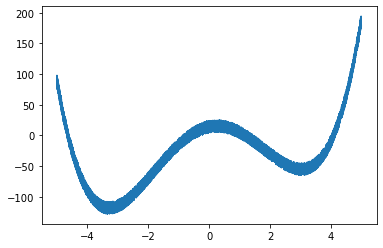

In [2]:
# This is just intended to generate some data for which the minima can be easily seen visually.
# It's a bit of a toy problem, but I think it's sufficient to illustrate the point. 
x = np.arange(0, 10000)/1000.0 - 5
y = x ** 4 - 20 * x ** 2 +  10 * x + 4 + np.random.rand(len(x)) * 20
plt.plot(x, y)

In [3]:
# reshape the matrix so it's compatible with keras
x = x.reshape(len(x), 1)

In [5]:
import ipywidgets

#this is our basic model that we're going to use to reconstruct the function

input_layer = Input(shape=(1,))
hidden_layer = Dense(12, activation='elu')(input_layer)
hidden_layer = Dense(9, activation='elu')(hidden_layer)
hidden_layer = Dense(6, activation='elu')(hidden_layer)
hidden_layer = Dense(3, activation='elu')(hidden_layer)
decoder = Dense(1, activation='linear')(hidden_layer)

model = Model(input_layer, decoder)
model.compile(loss='mse', optimizer='rmsprop')
model.fit(x, y, batch_size=16, epochs=20, validation_data=(x,y), verbose = 1)

Epoch 1/20


2021-11-24 16:08:00.201724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 3311.2856

2021-11-24 16:08:06.383790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 9s 13ms/step - loss: 3311.2856 - val_loss: 2486.7341
Epoch 2/20
625/625 [==============================] - 8s 12ms/step - loss: 2407.0864 - val_loss: 2313.9390
Epoch 3/20
625/625 [==============================] - 8s 12ms/step - loss: 2106.3911 - val_loss: 1828.0315
Epoch 4/20
625/625 [==============================] - 8s 12ms/step - loss: 1511.7341 - val_loss: 1181.1709
Epoch 5/20
625/625 [==============================] - 8s 12ms/step - loss: 874.4863 - val_loss: 573.7392
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 329.9647 - val_loss: 151.8475
Epoch 7/20
625/625 [==============================] - 8s 13ms/step - loss: 89.1691 - val_loss: 69.1948
Epoch 8/20
625/625 [==============================] - 8s 13ms/step - loss: 61.8714 - val_loss: 64.6847
Epoch 9/20
625/625 [==============================] - 8s 13ms/step - loss: 54.5841 - val_loss: 54.7049
Epoch 10/20
625/625 [==============================] - 8s 13ms/s

In [17]:
model.fit(x, y, batch_size=4, epochs=20, validation_data=(x,y), verbose = 1)

Epoch 1/20
2249/2500 [=========================>....] - ETA: 2s - loss: 383.7872

KeyboardInterrupt: 

In [6]:
# predict the curve again. Yes this is a self prediction, but we'll leave the cross validation as 
# an exercise for the reader
p = model.predict(x)

2021-11-24 16:11:03.116934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


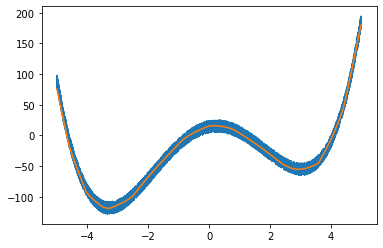

In [7]:
# unsurprisingly it is able to replicate the original function
plt.plot(x, y)
plt.plot(x, p)

In [8]:
# we're going to freeze the model
model.trainable = False

### Optimization

The previous section was a pretty straightforward data generation and training of the neural network. Within the next section we're going to be trying to find the optimal solution.

Essentailly, we want to have a "layer" whose weights can be optimized, and which serve as an input to the trained model. 

In [9]:
# I don't really care about the input and output at this point 
sample_input = np.ones(10000).reshape(10000, 1)
#this doesn't matter at all, we're just going to minimize the function
sample_output = np.zeros(10000)

In [10]:
# this loss function is just the value of the function we're trying to minimize.
# all of the inputs are the same and so we don't really care about y_true
def my_loss_fn(y_true, y_pred):
    return tf.reduce_mean(y_pred, axis=-1) 

In [11]:
class custom_layer(Layer):
    def  __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(custom_layer,self).__init__(**kwargs)
    def build(self,input_shape):
        output_shape = self.compute_output_shape(input_shape)
        self.W=self.add_weight(name='kernel',
                           shape=(1,) + output_shape[1:],
                           initializer='uniform'                              ,
                           trainable=True)
        self.built = True
  # this self.built is necessary .
    def call(self,x):
        return x * self.W
    def compute_output_shape(self, input_shape):
        return(input_shape)

In [12]:
# input layer
new_input_layer =  Input(shape=(1,))
l = custom_layer(1)
# this is the layer whose weight we believe is going to be the minimum
new_weight_layer = l(new_input_layer)
# the model that we trained previously
transfer = model(new_weight_layer, training=False)

optimization_model = Model(new_input_layer, transfer)
optimization_model.compile('rmsprop', loss = my_loss_fn)
optimization_model.summary()
# basic training framework that is used in keras
optimization_model.fit(sample_input, sample_output, batch_size=4, epochs=5, validation_data=(x,y), verbose = 1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
custom_layer (custom_layer)  (None, 1)                 1         
_________________________________________________________________
model_1 (Functional)         (None, 1)                 226       
Total params: 227
Trainable params: 1
Non-trainable params: 226
_________________________________________________________________
Epoch 1/5
  15/2500 [..............................] - ETA: 18s - loss: 15.1091

2021-11-24 16:11:16.654225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2496/2500 [============================>.] - ETA: 0s - loss: -31.7523

2021-11-24 16:11:33.100376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 26s 10ms/step - loss: -31.8596 - val_loss: 497.9928
Epoch 2/5
2500/2500 [==============================] - 26s 10ms/step - loss: -116.2405 - val_loss: 827.4851
Epoch 3/5
2500/2500 [==============================] - 26s 10ms/step - loss: -118.8931 - val_loss: 827.4851
Epoch 4/5
2500/2500 [==============================] - 26s 10ms/step - loss: -118.8931 - val_loss: 827.4854
Epoch 5/5
2500/2500 [==============================] - 25s 10ms/step - loss: -118.8931 - val_loss: 827.4849


In [13]:
optimum_x = l.get_weights()[0][0][0]
print(optimum_x)
optimum_y = model.predict(np.array([optimum_x]))

-3.3066943


2021-11-24 16:13:53.360575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


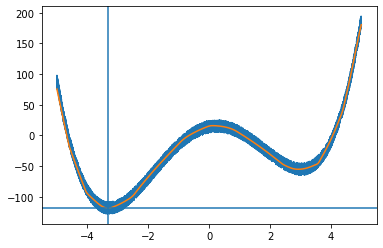

In [14]:
plt.plot(x, y)
plt.plot(x, p)

plt.axvline(x=optimum_x)
plt.axhline(y=optimum_y)